In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

from IPython.display import clear_output

import sys

sys.path.append("..")

from classes import Kernel, ModelParameters, MultiTaskLoss, MLP, PriceImpact
from utils import non_markovian_midprice, generate_time_one_time_two

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config("config.yaml")

In [3]:
rng = np.random.default_rng(123)

# num_paths = config.num_paths
# num_timesteps = config.num_timesteps
# final_time = config.final_time
# initial_price = config.initial_price
# decomp_dim = config.decomp_dim
# num_episodes = config.num_episodes
# batch_size = config.batch_size
# learning_rate = config.learning_rate

num_paths = 1
num_timesteps = 1000
final_time = 1
initial_price = 1
decomp_dim = 1
dt = final_time / num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

kappa_true = 1
# permenant_price_impact_func = lambda x: kappa_true * x
permenant_price_impact_func = lambda x: kappa_true * np.sign(x) * np.sqrt(np.abs(x))
K0 = 1

In [4]:
parameter_dim = 1

# def kernel_function(x, y, alpha):

#     if len(alpha.shape) < 2:
#         term_one = alpha[0]
#         term_two = np.exp(-np.abs(x-y)*alpha[2])
#         term_two = np.exp(-np.abs(x-y)*alpha[3])
#         return_val = term_one + (1-term_one)*(alpha[1]*term_two+(1-alpha[1])*term_two)
#     else:
#         term_one = alpha[:, 0]
#         term_two = np.exp(-(np.abs(x-y)*alpha[:, 2]))
#         term_two = np.exp(-(np.abs(x-y)*alpha[:, 3]))
#         return_val = term_one + (1-term_one)*(alpha[:, 1] * term_two+ (1-alpha[:, 1]) * term_two)

#     return return_val

def kernel_function(x, y, alpha):

    if len(alpha.shape) < 2:
        return_val = 1 / (1+np.abs(x-y)**alpha[0])
    else:
        return_val = 1 / (1+np.abs(x-y)**alpha[:, 0])

    return return_val

# Fit First Decomposition

In [5]:
learning_rate = 1e-4
num_episodes = 250_000
batch_size = 512

if parameter_dim ==4:
    network = MLP(decomp_dim=decomp_dim,
                  parameter_start=torch.FloatTensor([0.1, 1, 1, 0.05, 10]),
                  learn_price_impact=True)
else:
    network = MLP(decomp_dim=decomp_dim,
                  parameter_start=torch.FloatTensor([0.1, 0.5]),
                  learn_price_impact=True)

kernel_mtloss = MultiTaskLoss(num_losses=2, lagrangian=True)

optimizer = torch.optim.Adam(
    params=[*network.kernel_func.parameters(), *kernel_mtloss.parameters()], 
    lr=learning_rate
)

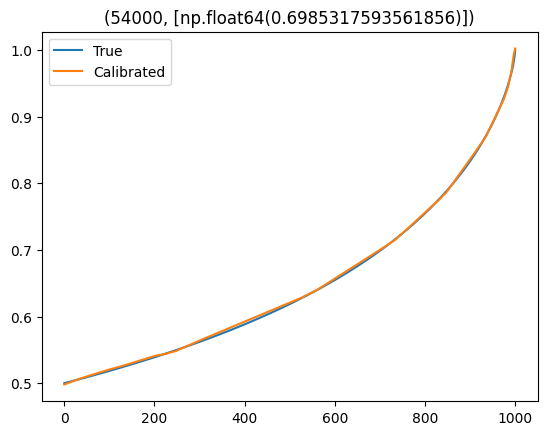

KeyboardInterrupt: 

In [6]:
loss_list = []
for i in tqdm(range(num_episodes)):

    time_one = (
        torch.FloatTensor([num_timesteps for _ in range(batch_size)]).reshape(-1, 1) * dt
    )
    time_two = (
        torch.FloatTensor(rng.uniform(0, num_timesteps, batch_size)).reshape(-1, 1) * dt
    )

    if parameter_dim == 4:
        alpha_one = rng.uniform(0, 1, (batch_size, 2))
        k_one = rng.uniform(0, 0.1, (batch_size, 1))
        k_two = rng.uniform(5, 10, (batch_size, 1))
        alpha = np.hstack([alpha_one, k_one, k_two])
    else:
        alpha = rng.uniform(0.001, 1, (batch_size, 1))

    K_one_two = network.approx_func(
        time_one.reshape(batch_size, 1),
        time_two.reshape(batch_size, 1),
        parameters=torch.FloatTensor(alpha),
    ).flatten()

    K_one_one = network.approx_func(
        time_one.reshape(batch_size, 1),
        time_one.reshape(batch_size, 1),
        parameters=torch.FloatTensor(alpha),
    ).flatten()
    
    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy().flatten(), time_two.detach().numpy().flatten(), alpha=alpha)
    ).flatten()

    true_error = torch.abs(true_val - K_one_two)
    one_error = torch.abs(K0 - K_one_one)

    # delta = torch.FloatTensor(rng.uniform(-num_timesteps, num_timesteps, (batch_size, 1)))
    # K_one_two_delta = network.approx_func(time_one+delta, time_one+delta, parameters=alpha).flatten()
    # translation_error = torch.abs(K_one_two - K_one_two_delta)

    loss_tensor = torch.hstack(
                [
                    (true_error**2).mean(),
                    (one_error**2).mean(),
                    # (translation_error**2).mean()
                ]
            )

    if len(loss_tensor) == 1:
        loss = loss_tensor.mean()
    else:
        loss = kernel_mtloss(loss_tensor)

    loss_list.append(loss.detach().item())

    network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(network.kernel_func.parameters(), 1)
    optimizer.step()

    network.zero_grad()
    optimizer.zero_grad()

    if i % 1_000 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        if parameter_dim == 4:
            alpha_one = rng.uniform(0, 1, (2))
            k_one = rng.uniform(0, 0.1, (1))
            k_two = rng.uniform(5, 10, (1))
            alpha = np.hstack([alpha_one, k_one, k_two])
        else:
            alpha = rng.uniform(0.001, 1, (1))

        for _ in range(0, num_timesteps + 1):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([_ * dt]).reshape(1, -1),
                torch.FloatTensor(alpha).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for _ in range(0, num_timesteps + 1):
            val = kernel_function(s_val * dt, _ * dt, alpha)
            kernel_plot_two.append(val)

        plt.title((i, list(alpha)))
        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

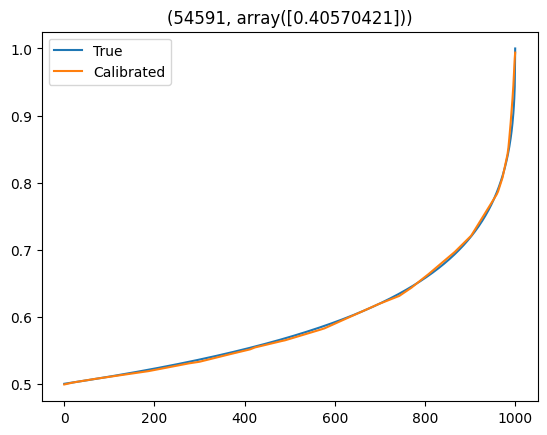

In [7]:
s = 1
s_val = num_timesteps * s
kernel_plot = []
kernel_plot_two = []

if parameter_dim == 4:
    alpha_one = rng.uniform(0,1, (2))
    k_one = rng.uniform(0, 1, (1))
    k_two = rng.uniform(0, 10, (1))
    alpha = np.hstack([alpha_one, k_one, k_two])
else:
    alpha = rng.uniform(0.001, 1, (1))

for _ in range(0, num_timesteps + 1):
    k_s_t = network.approx_func(
        torch.FloatTensor([s_val * dt]).reshape(-1, 1),
        torch.FloatTensor([_ * dt]).reshape(1, -1),
        torch.FloatTensor(alpha).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

for _ in range(0, num_timesteps + 1):
    val = kernel_function(s_val * dt, _ * dt, alpha=alpha)
    kernel_plot_two.append(val)

plt.title((i, alpha))
plt.plot(kernel_plot_two, label="True")
plt.plot(kernel_plot, label="Calibrated")
plt.legend()
plt.show()

# Generate Data

In [8]:
nu_vals = rng.integers(-100, 100, size=(num_timesteps, num_paths))
alpha_true = 0.5
sigma_true = 0.01

power_kernel_function = lambda x, y, alpha: 1 / (1 + np.abs(x - y) ** alpha)
true_kernel_function = partial(power_kernel_function, alpha=0.5)

sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=true_kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

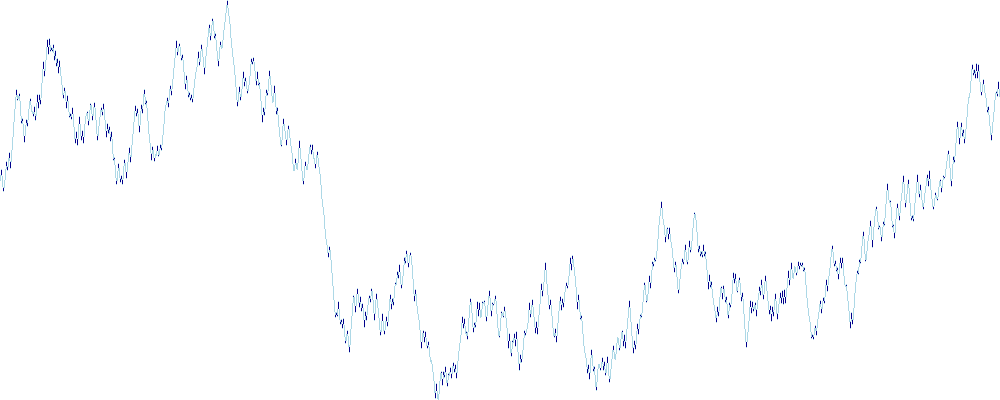

In [9]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# NN Approach

In [10]:
learning_rate = 1e-3
batch_size = 1
num_episodes = 10_000

comb_optimizer = torch.optim.Adam(
    params=[*network.model_parameters.parameters(), *network.price_impact.parameters()], lr=learning_rate
)

scheduler_steps = 50
scheduler = torch.optim.lr_scheduler.LinearLR(
    comb_optimizer, start_factor=1.0, end_factor=0.01, total_iters=scheduler_steps
)

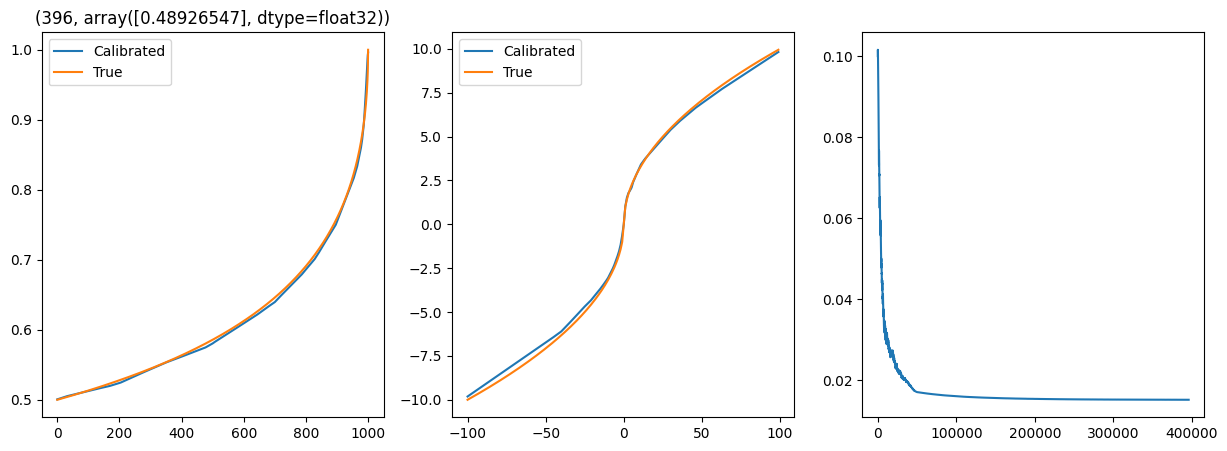

KeyboardInterrupt: 

In [11]:
network.eval()
loss_vals = {}
sigma_tracker = {}
alpha_tracker = {}

for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    alpha_tracker[episode] = []

    if episode == 0:
        sigma_tracker[episode].append(network.sigma.detach().item())

    for batch_index in range(1, int(num_paths / batch_size) + 1):

        lower_bound = int((batch_index - 1) * batch_size)
        upper_bound = int((batch_index) * batch_size)

        B_n_t = torch.zeros((batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, num_timesteps - 1)

        # Shuffle Timestamps
        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            sigma = network.sigma
            alpha = network.params.reshape(1, parameter_dim)

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = network.price_impact(
                batch_nu_vals_t
            ).reshape(batch_size)

            time_tensor = torch.FloatTensor([num_timesteps * dt]).reshape(-1, 1)
            # f_vals = network(time_tensor)
            # K_t_t = network.approx_func(time_tensor.reshape(-1,1), time_tensor.reshape(-1,1)).flatten()
            K_t_t = torch.FloatTensor([K0])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            all_time_tensor = (torch.arange(num_timesteps-timestep, num_timesteps) * dt).reshape(-1, 1)
            B_n_t = torch.zeros((1, batch_size, decomp_dim))
            d_B_n_s = (
                network(all_time_tensor, torch.tile(alpha, dims=(timestep, 1))).reshape(timestep, 1, decomp_dim)
                * network.price_impact(
                    torch.FloatTensor(batch_nu_vals[:timestep]).reshape(
                        timestep, batch_size, 1
                    )
                ).reshape(timestep, batch_size, 1)
                * dt
            )

            # Do I want [:-1] or not?
            B_n_t = torch.vstack([B_n_t, d_B_n_s])
            B_n_t = torch.sum(B_n_t, axis=0)

            delta = torch.FloatTensor([dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (
                    network(time_plus_delta, alpha.reshape(-1, parameter_dim)).reshape(-1, 1)
                    - network(time_minus_delta, alpha.reshape(-1, parameter_dim)).reshape(-1, 1)
                )
                / (2 * delta)
            ).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(batch_size) * K_t_t

            f_x_t_two = (
                B_n_t.reshape(batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = sigma
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * dt))

            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * dt) ** 2) / (
                2 * dt * (L_x_t**2)
            )

            likely_hood_loss = (term_one + term_two).mean()
            
            loss = likely_hood_loss

            network.zero_grad()
            comb_optimizer.zero_grad()

            loss.backward()
            comb_optimizer.step()

            network.zero_grad()
            comb_optimizer.zero_grad()

            sigma_tracker[episode].append(network.sigma.detach().item())

    scheduler.step()

    if episode % 2 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        alpha = network.params
        sigma = network.sigma

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        for i in range(0, num_timesteps + 1):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([i * dt]).reshape(1, -1),
                alpha.reshape(-1, parameter_dim)
            )
            kernel_plot.append(k_s_t.detach().item())

        for i in range(0, num_timesteps + 1):
            val = true_kernel_function(i * dt, s_val * dt)
            kernel_plot_two.append(val)

        ax[0].set_title((episode, network.params.detach().numpy()))
        ax[0].plot(range(0, num_timesteps + 1), kernel_plot, label="Calibrated")
        ax[0].plot(range(0, num_timesteps + 1), kernel_plot_two, label="True")
        ax[0].legend()

        pi_plot = []
        pi_plot_true = []

        for plot_val in range(-100, 100):
            pred_pi = network.price_impact(torch.FloatTensor([plot_val]))
            pi_plot.append(pred_pi.detach().item())

        for plot_val in range(-100, 100):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        ax[1].plot(range(-100, 100), pi_plot, label="Calibrated")
        ax[1].plot(range(-100, 100), pi_plot_true, label="True")
        ax[1].legend()

        ax[2].plot(np.hstack([_ for _ in sigma_tracker.values()]))

        plt.show()

In [ ]:
s = 1
s_val = num_timesteps * s
kernel_plot = []
kernel_plot_two = []

alpha = network.params
sigma = network.sigma
alpha = alpha.reshape(1, parameter_dim)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(0, num_timesteps + 1):
    k_s_t = network.approx_func(
        torch.FloatTensor([s_val * dt]).reshape(-1, 1),
        torch.FloatTensor([i * dt]).reshape(1, -1),
        alpha.reshape(-1, parameter_dim)
    )
    kernel_plot.append(k_s_t.detach().item())

for i in range(0, num_timesteps + 1):
    val = true_kernel_function(i * dt, s_val * dt)
    kernel_plot_two.append(val)

ax[0].set_title(episode)
ax[0].plot(range(0, num_timesteps + 1), kernel_plot, label="Calibrated")
ax[0].plot(range(0, num_timesteps + 1), kernel_plot_two, label="True")
ax[0].legend()

pi_plot = []
pi_plot_true = []

for plot_val in range(-100, 100):
    pred_pi = network.price_impact(torch.FloatTensor([plot_val]))
    pi_plot.append(pred_pi.detach().item())

for plot_val in range(-100, 100):
    val = permenant_price_impact_func(plot_val)
    pi_plot_true.append(val)

ax[1].plot(range(-100, 100), pi_plot, label="Calibrated")
ax[1].plot(range(-100, 100), pi_plot_true, label="True")
ax[1].legend()

ax[2].plot(np.hstack([_ for _ in sigma_tracker.values()]))

plt.show()

RuntimeError: shape '[1, 4]' is invalid for input of size 1

# Validation Prices

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(
    1, len(loss_types), figsize=(5 * len(loss_types), 5), constrained_layout=True
)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(
        pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()])
        .rolling(num_timesteps)
        .mean()
        .values
    )
    ax[plot_index].set_title(loss_type)

plt.show()

# Distribution Plots

In [ ]:
val_nu_vals = rng.integers(-80, 100, size=(num_timesteps, 1_000))

val_inital_prices = np.ones((1, 1_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(
    inital_prices=val_inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=val_nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=1_000,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

In [ ]:
network.eval()
network.eval()

num_paths = 1_000

sim_nu_vals = rng.uniform(-80, 100, size=(num_timesteps, num_paths))
all_time_tensor = (torch.arange(0, num_timesteps) * dt).reshape(-1, 1)

noise = np.zeros((1, num_paths))
d_W_t = (
    network.sigma.detach().item()
    * rng.standard_normal(size=(num_timesteps, num_paths))
    * (dt**0.5)
)
noise = np.vstack([noise, d_W_t])

S_t = torch.ones((1, num_paths)) * initial_price
B_n_t = torch.zeros((1, num_paths, decomp_dim)).detach().numpy()

d_B_n_s = (
    network(all_time_tensor).detach().numpy().reshape(num_timesteps, 1, decomp_dim)
    * network.numpy_permenant_price_impact_func(
        sim_nu_vals.reshape(num_timesteps, num_paths, 1)
    ).reshape(num_timesteps, num_paths, 1)
    * dt
)

B_n_t = np.vstack([B_n_t, d_B_n_s])[:-1]
B_n_t = np.cumsum(B_n_t, axis=0)

f_prime_t = (
    torch.vstack(
        [
            torch.autograd.functional.jacobian(network, _, create_graph=True).flatten()
            for _ in all_time_tensor
        ]
    )
    .detach()
    .numpy()
    .reshape(num_timesteps, 1, decomp_dim)
)

dt_term_one = network.numpy_permenant_price_impact_func(
    sim_nu_vals.reshape(num_timesteps, num_paths, 1)
).reshape(num_timesteps, num_paths) * network.approx_func(
    all_time_tensor, all_time_tensor
).detach().numpy().reshape(
    num_timesteps, 1
)
dt_term_two = (f_prime_t * B_n_t).sum(axis=2)

dt_term = (dt_term_one + dt_term_two) * dt

d_S_terms = dt_term + d_W_t

S_t = np.vstack([S_t, d_S_terms])
S_t = np.cumsum(S_t, axis=0)

nn_sim_prices = S_t

In [ ]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# Distribution Plots

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label="True")
ax[0].plot(nn_sim_prices.mean(axis=1), label="Simulated")
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label="True")
ax[1].plot(nn_sim_prices.std(axis=1), label="Simulated")
ax[1].legend()

plt.show()

In [ ]:
final_sim_prices = nn_sim_prices[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color="blue", label="Calibrated")
sns.kdeplot(final_val_sim_prices, alpha=0.4, color="red", label="True")
plt.legend()
plt.show()